In [1]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np
import matplotlib.pyplot as plt

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import plot_data, plot_ratio, plot_pull, get_ratio_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename

import backends.plot as plot


Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
#  Inputs config

input_fname = "../Data/SM_QCD_rivet_output.pickle"


In [3]:
#  Model config

output_size_per_stage     = 15
max_epochs                = 50
batch_size                = 200
epoch_increase_per_level  = 20
early_stopping_patience   = 10
early_stopping_min_delta  = 0
validation_split          = 0.5

white_linear_fraction_data  = 0.3
white_linear_fraction_gauss = 0.
whitening_num_points        = 200
whitening_func_form         = "step"
whitening_alpha, whitening_beta, whitening_gamma = 3, 2, 2

load_whitening_funcs = ".whitening_funcs.pickle"
save_whitening_funcs = None

load_model_dir = None # ".QCD_density_model"
save_model_dir = ".QCD_density_model" # ".QCD_density_model"

learning_rate = 0.001     # 0.01 for SGD or 0.001 otherwise
optimiser     = "adam"     # SGD, Adam or AdaDelta


In [4]:
#  Data config

observable_limits = {}
observable_limits ["m_ll"      ] = [75    , 105  ]
observable_limits ["pT_ll"     ] = [0     , 900  ]
observable_limits ["theta_ll"  ] = [0     , np.pi]
observable_limits ["rap_ll"    ] = [0     , 2.2  ]
observable_limits ["m_jj"      ] = [150   , 5000 ]
observable_limits ["pT_jj"     ] = [0     , 900  ]
observable_limits ["theta_jj"  ] = [0     , np.pi]
observable_limits ["rap_jj"    ] = [0     , 4.4  ]
observable_limits ["pT_j1"     ] = [40    , 1200 ]
observable_limits ["pT_j2"     ] = [35    , 1200 ]
observable_limits ["Dy_j_j"    ] = [0     , 8.8  ]
observable_limits ["Dphi_j_j"  ] = [-np.pi, np.pi]
observable_limits ["N_jets"    ] = [2     , 5    ]
observable_limits ["N_gap_jets"] = [0     , 2    ]

remove_observables = ["N_jets", "pT_ll", "rap_ll", "theta_ll", "pT_jj", "theta_jj", "rap_jj", "pT_j1", "pT_j2", "N_gap_jets"]

int_observables = ["N_jets", "N_gap_jets"]

observables_order = ["m_jj", "m_ll", "Dphi_j_j", "Dy_j_j"]

plot.observable_limits = observable_limits
plot.int_observables   = int_observables

num_observables = len(observables_order)


In [5]:
#  Load and format the data
#

print(f"Creating QCD data table")
print(f" -- events from file {input_fname}")
data_table = DataTable(input_fname)
print(f" -- Table created with {data_table.get_num_events()} events")
for observable, limits in observable_limits.items() :
    print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
    data_table.filter(observable, limits[0], limits[1])
    print(f" -- {data_table.get_num_events()} events survived")
for observable in remove_observables :
    print(f" -- removing observable {observable}")
    data_table.remove_column(observable)
print(" -- ordering observables")
data_table.reorder(*observables_order)
data_table.print_summary()
    

Creating QCD data table
 -- events from file ../Data/SM_QCD_rivet_output.pickle
 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 126626 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 126625 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 126625 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 123851 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 120416 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 120416 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 120416 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 120416 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 120409 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 120349 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 120349 events survived
 -- 

In [6]:

whitening_funcs = None
if (type(load_whitening_funcs) != type(None)) :
    print(f"Loading whitening functions from file {load_whitening_funcs}")
    whitening_funcs = pickle.load(open(load_whitening_funcs, "rb"))

axis_configs = [[observable_limits[key][0], observable_limits[key][1], whitening_num_points,  white_linear_fraction_data, white_linear_fraction_gauss] for key in data_table.keys]

#  Seperate data from weights
observable_data, weight_data = data_table.get_observables_and_weights()
#  Whiten data
print(f"Whitening dataset")
white_data_to_fit, whitening_funcs = whiten_axes (observable_data, data_table.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=data_table.get_weights(), 
                                                  func_form=whitening_func_form, alpha=whitening_alpha, beta=whitening_beta, gamma=whitening_gamma)

weights_to_fit = weight_data / np.sum(weight_data)


Loading whitening functions from file .whitening_funcs.pickle
Whitening dataset


Filter efficiency is 100.000%


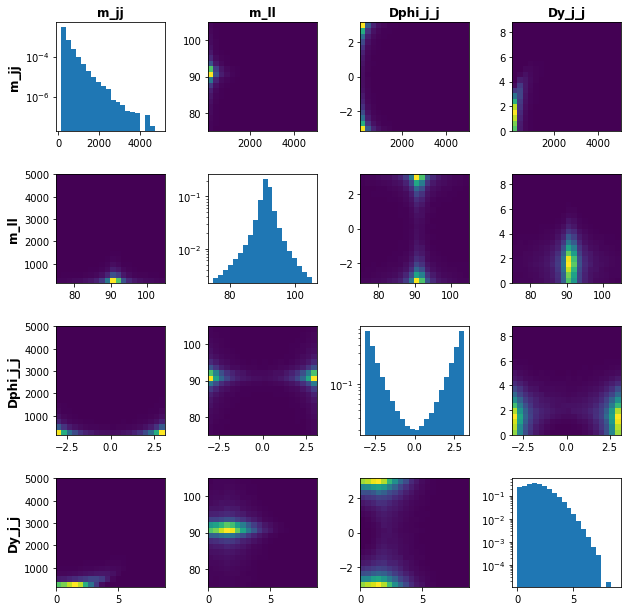

Filter efficiency is 100.000%


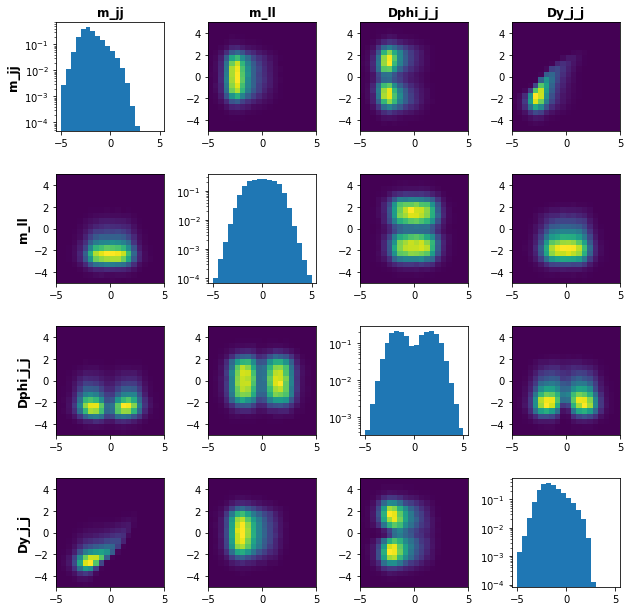

In [7]:

plot_data(observable_data  , weight_data   , keys=data_table.keys, bins=20, lims=True )
plot_data(white_data_to_fit, weights_to_fit, keys=data_table.keys, bins=20, lims=False)


In [8]:
#  Load model if requested, otherwise build and fit
#

if type(load_model_dir) != type(None) :
    density_model = DensityModel.from_dir(load_model_dir)
else :
    #  Create density model
    density_model = DensityModel(name            = "QCD_density_model", 
                                 num_gaussians   = output_size_per_stage, 
                                 num_conditions  = 1, 
                                 num_observables = data_table.get_num_observables(), 
                                 types           = data_table.types,
                                 int_limits      = {idx:observable_limits[obs] for idx,(obs,t) in enumerate(zip(data_table.keys, data_table.types)) if t == int},
                                 range_limits    = {idx:[np.min(white_data_to_fit[:,idx]), np.max(white_data_to_fit[:,idx])] for idx in range(num_observables)},
                                 verbose         = True,
                                 learning_rate   = learning_rate,
                                 optimiser       = optimiser)
    fit_times = {}
    for obs_idx in range(white_data_to_fit.shape[1]) :
        fit_start_time = time.time()
        num_epochs = max_epochs + obs_idx*epoch_increase_per_level
        density_model.fit({0:white_data_to_fit}, 
                          {0:weights_to_fit},
                          observable                = obs_idx,
                          max_epochs_per_observable = num_epochs,
                          early_stopping_patience   = early_stopping_patience,
                          early_stopping_min_delta  = early_stopping_min_delta,
                          validation_split          = validation_split,
                          batch_size_per_observable = batch_size)
        fit_times [obs_idx] = [num_epochs, time.time() - fit_start_time]


INFO       DensityModel.construct      Set model name           : QCD_density_model
INFO       DensityModel.construct      Set model num_gaussians  : 15
INFO       DensityModel.construct      Set model num_conditions : 1
INFO       DensityModel.construct      Set model num_observables: 4
INFO       DensityModel.construct      Set observable types     : [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
INFO       DensityModel.build          Building model segment: QCD_density_model_observable0 for observable index 0
Creating continuous density model: QCD_density_model_observable0
  - num_conditions_in  is 1
  - num_observables_in is 0
  - num_gaussians      is 15
  - range              is -5.0000 - 2.9192
Instructions for updating:
Colocations handled automatically by placer.
Model: "QCD_density_model_observable0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Para

Model: "QCD_density_model_observable2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 7)            14          input_4[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 6)            18          input_5[0][0]                    
______________________________________________________________________

INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 50
INFO       DensityModel.fit              -  Training setting: batch_size = 200
INFO       DensityModel.fit              -  Training setting: validation_split = 0.5
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 10
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 60174 samples, validate on 60175 samples
Epoch 1/50
60174/60174 [==============================] - 3s 52us/step - loss: 1.6008e-05 - val_loss: 1.3868e-05
Epoch 2/50
60174/60174 [==============================] - 2s 26us/step - loss: 1.2533e-05 - val_loss: 1.1830e-05
Epoch 3/50
60174/60174 [==============================] - 2s 26us/step - loss: 1.1700e-05 - val_loss: 1.1549e-05
Epoch 4/50
60174/60174 [==============================] - 2s 27us/step - loss: 1.1550e-05 - val_loss: 1.1488e-05
Epoch 5/50


60174/60174 [==============================] - 2s 30us/step - loss: 1.3796e-05 - val_loss: 1.3807e-05
Epoch 31/70
60174/60174 [==============================] - 2s 30us/step - loss: 1.3797e-05 - val_loss: 1.3806e-05
Epoch 32/70
60174/60174 [==============================] - 2s 29us/step - loss: 1.3797e-05 - val_loss: 1.3806e-05
Epoch 33/70
60174/60174 [==============================] - 2s 29us/step - loss: 1.3797e-05 - val_loss: 1.3809e-05
Epoch 34/70
60174/60174 [==============================] - 2s 30us/step - loss: 1.3797e-05 - val_loss: 1.3806e-05
Epoch 35/70
60174/60174 [==============================] - 2s 32us/step - loss: 1.3797e-05 - val_loss: 1.3807e-05
Epoch 36/70
60174/60174 [==============================] - 2s 33us/step - loss: 1.3796e-05 - val_loss: 1.3807e-05
Epoch 37/70
60174/60174 [==============================] - 2s 34us/step - loss: 1.3797e-05 - val_loss: 1.3808e-05
Epoch 38/70
60174/60174 [==============================] - 2s 32us/step - loss: 1.3796e-05 - val_los

Epoch 54/90
60174/60174 [==============================] - 2s 29us/step - loss: 1.5497e-05 - val_loss: 1.5552e-05
Epoch 55/90
60174/60174 [==============================] - 2s 29us/step - loss: 1.5497e-05 - val_loss: 1.5550e-05
Epoch 56/90
60174/60174 [==============================] - 2s 30us/step - loss: 1.5497e-05 - val_loss: 1.5545e-05
Epoch 57/90
60174/60174 [==============================] - 2s 29us/step - loss: 1.5496e-05 - val_loss: 1.5549e-05
Epoch 58/90
60174/60174 [==============================] - 2s 31us/step - loss: 1.5498e-05 - val_loss: 1.5542e-05
Epoch 59/90
60174/60174 [==============================] - 2s 29us/step - loss: 1.5499e-05 - val_loss: 1.5540e-05
Epoch 60/90
60174/60174 [==============================] - 2s 29us/step - loss: 1.5497e-05 - val_loss: 1.5542e-05
Epoch 61/90
60174/60174 [==============================] - 2s 29us/step - loss: 1.5497e-05 - val_loss: 1.5542e-05
Epoch 62/90
60174/60174 [==============================] - 2s 28us/step - loss: 1.5496e-

60174/60174 [==============================] - 2s 30us/step - loss: 9.7086e-06 - val_loss: 9.7423e-06
Epoch 39/110
60174/60174 [==============================] - 2s 30us/step - loss: 9.7055e-06 - val_loss: 9.7428e-06
Epoch 40/110
60174/60174 [==============================] - 2s 29us/step - loss: 9.7007e-06 - val_loss: 9.7266e-06
Epoch 41/110
60174/60174 [==============================] - 2s 29us/step - loss: 9.6960e-06 - val_loss: 9.7199e-06
Epoch 42/110
60174/60174 [==============================] - 2s 29us/step - loss: 9.6918e-06 - val_loss: 9.7422e-06
Epoch 43/110
60174/60174 [==============================] - 2s 29us/step - loss: 9.6883e-06 - val_loss: 9.7205e-06
Epoch 44/110
60174/60174 [==============================] - 2s 30us/step - loss: 9.6862e-06 - val_loss: 9.7234e-06
Epoch 45/110
60174/60174 [==============================] - 2s 32us/step - loss: 9.6846e-06 - val_loss: 9.7091e-06
Epoch 46/110
60174/60174 [==============================] - 2s 33us/step - loss: 9.6850e-06 -

In [9]:
#  Use this cell to add training epochs to whichever indices appear undertrained

improve_indices   = [i for i in range(num_observables)]
impove_batch_size = 5000
impove_num_epochs = 200
improve_patience  = 10
improve_validation_split = 0.5


if type(load_model_dir) != type(None) :
    density_model = DensityModel.from_dir(load_model_dir)
else :
    added_fit_times = {}
    for obs_idx in improve_indices :
        fit_start_time = time.time()
        density_model.fit({0:white_data_to_fit}, 
                          {0:weights_to_fit},
                          observable                = obs_idx,
                          max_epochs_per_observable = impove_num_epochs,
                          early_stopping_patience   = improve_patience,
                          validation_split          = improve_validation_split,
                          batch_size_per_observable = impove_batch_size)
        added_fit_times [obs_idx] = [impove_num_epochs, time.time() - fit_start_time]
    

INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 200
INFO       DensityModel.fit              -  Training setting: batch_size = 5000
INFO       DensityModel.fit              -  Training setting: validation_split = 0.5
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 10
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 60174 samples, validate on 60175 samples
Epoch 1/200
60174/60174 [==============================] - 0s 4us/step - loss: 1.1552e-05 - val_loss: 1.1462e-05
Epoch 2/200
60174/60174 [==============================] - 0s 4us/step - loss: 1.1552e-05 - val_loss: 1.1463e-05
Epoch 3/200
60174/60174 [==============================] - 0s 4us/step - loss: 1.15

60174/60174 [==============================] - 0s 5us/step - loss: 9.6114e-06 - val_loss: 9.6815e-06
Epoch 9/200
60174/60174 [==============================] - 0s 6us/step - loss: 9.6110e-06 - val_loss: 9.6812e-06
Epoch 10/200
60174/60174 [==============================] - 0s 6us/step - loss: 9.6110e-06 - val_loss: 9.6833e-06
Epoch 11/200
60174/60174 [==============================] - 0s 5us/step - loss: 9.6148e-06 - val_loss: 9.6828e-06
Epoch 12/200
60174/60174 [==============================] - 0s 5us/step - loss: 9.6118e-06 - val_loss: 9.6846e-06
Epoch 13/200
60174/60174 [==============================] - 0s 6us/step - loss: 9.6111e-06 - val_loss: 9.6822e-06
Epoch 14/200
60174/60174 [==============================] - 0s 6us/step - loss: 9.6098e-06 - val_loss: 9.6813e-06
Epoch 15/200
60174/60174 [==============================] - 0s 6us/step - loss: 9.6103e-06 - val_loss: 9.6814e-06
Epoch 16/200
60174/60174 [==============================] - 0s 5us/step - loss: 9.6100e-06 - val_loss:

In [10]:
#  Save model if requested

if type(save_model_dir) != type(None) :
    density_model.save_to_dir(save_model_dir)
    

In [11]:
#  Generate a large number of datapoints at 0.
#

n_gen = 100000

print(f"Generating {n_gen} fake datapoints")
start = time.time()

fake_white_datapoints_SM = density_model.sample(n_gen, [0])
end = time.time()
print(f"{n_gen} datapoints generated at cWtil=0 in {int(end-start):.0f}s")


Generating 100000 fake datapoints
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 3
100000 datapoints generated at cWtil=0 in 49s


In [12]:
#  Unwhiten generated data
#

print("Unwhitening fake datapoints for cWtil=0")
start = time.time()
fake_datapoints_SM = unwhiten_axes(fake_white_datapoints_SM, whitening_funcs)
end = time.time()
print(f"{n_gen} datapoints unwhitened at cWtil=0 in {int(end-start):.0f}s")


Unwhitening fake datapoints for cWtil=0
100000 datapoints unwhitened at cWtil=0 in 2s


Filter efficiency is 100.000%


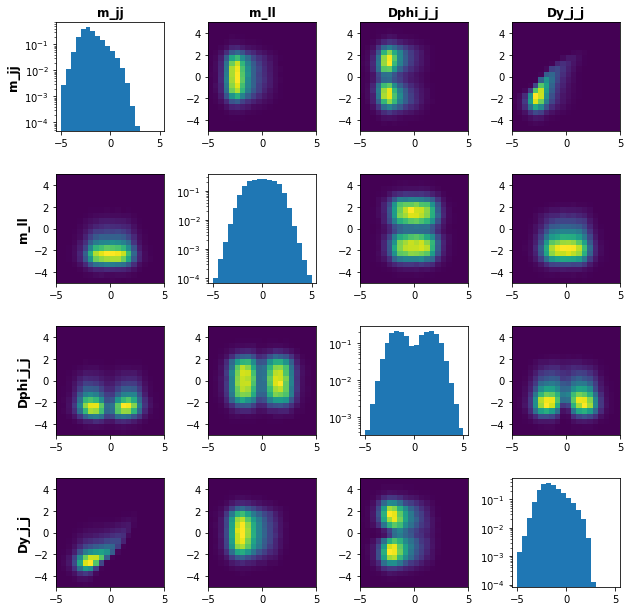

Filter efficiency is 100.000%


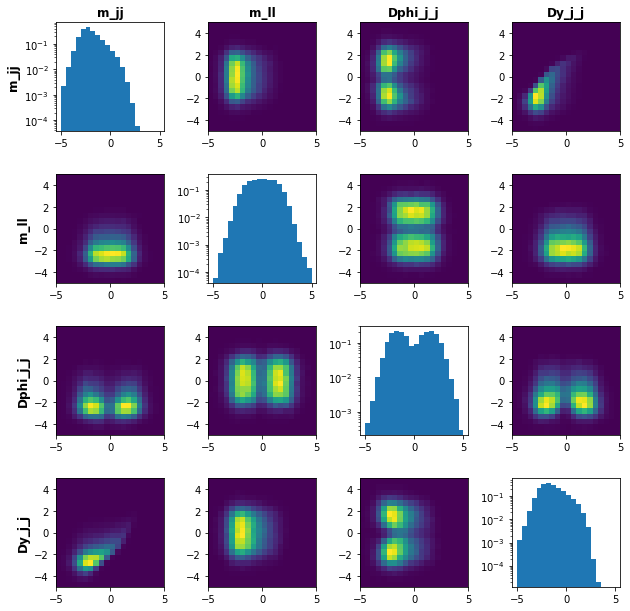

In [13]:
#  Plot original and generate data (total phase space)

plot_data(white_data_to_fit       , weights_to_fit, keys=data_table.keys, bins=20, lims=False)
plot_data(fake_white_datapoints_SM, None          , keys=data_table.keys, bins=20, lims=False)


In [14]:

#  Plot the datapoints provided
#
def plot_observable_on_axis (ax, observable, data_num, data_den, weights_num=None, weights_den=None, keys=None, cuts=[], save="", lims=True, bins=20, label=None, normed=True, ebar=False) :
    if type(weights_num) == type(None) :
        weights_num = np.ones(shape=(data_num.shape[0],))
    if type(keys) == type(None) :
        keys = [f"obs{i}" for i in range(len(data_num))]
    filtered_data_num, filtered_weights_num = data_num, weights_num
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for numerator")
        filtered_data_num, filtered_weights_num = filter_data (filtered_data_num, filtered_weights_num, keys, cut[0], cut[1], cut[2])
    
    if type(weights_den) == type(None) :
        weights_den = np.ones(shape=(data_den.shape[0],))
    filtered_data_den, filtered_weights_den = data_den, weights_den
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for denominator")
        filtered_data_den, filtered_weights_den = filter_data (filtered_data_den, filtered_weights_den, keys, cut[0], cut[1], cut[2])
    
    obs_idx = keys.index(observable)
    if lims : obs_lims = observable_limits[observable]
    else    : obs_lims = [-5., 5.]
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins = np.linspace(obs_lims[0], obs_lims[1], bins+1)
        
    data_x, data_z, data_ez = get_ratio_1D(filtered_data_den[:,obs_idx], filtered_data_num[:,obs_idx], bins, filtered_weights_den, filtered_weights_num, as_lines=True, normed=normed)
    data_z = np.nan_to_num(data_z)
    ax.plot(data_x, data_z-1., color="k", label=label)
    if ebar :ax.fill_between(data_x, data_z+data_ez-1, data_z-data_ez-1, alpha=0.3, color="grey")
    ax.set_xlim([bins[0], bins[-1]])
    
    ax.axhline(0    , linestyle="-" , c="grey", linewidth=2  )
    for h in [-0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4] :
        ax.axhline(h, linestyle="--", c="grey", linewidth=0.5)
        

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: divide by zero encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:2450: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: in

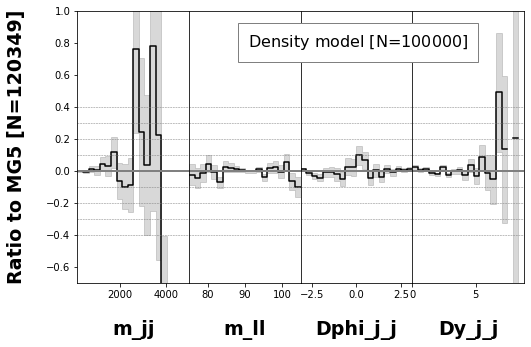

In [15]:

fig = plt.figure(figsize=(2*num_observables, 5))
for idx, obs in enumerate(observables_order) :
    ax = fig.add_subplot(1, num_observables, 1+idx)
    datapoints_true, weights_true = data_table.get_observables_and_weights()
    plot_observable_on_axis (ax, obs, fake_datapoints_SM, datapoints_true, None, weights_true, keys=data_table.keys, bins=20, normed=True, ebar=True)
    ax.set_xlabel(obs, weight="bold", fontsize=19, labelpad=20)
    if idx == 0 :
        ax.set_ylabel(f"Ratio to MG5 [N={datapoints_true.shape[0]}]", fontsize=19, labelpad=20, weight="bold")
    else :
        ax.set_yticks([])
    if idx == num_observables-1 :
        ax.text(0.5, 0.92, r"${\rm Density~model}"+f"$ [N={fake_datapoints_SM.shape[0]}]", fontsize=16, transform=ax.transAxes, ha="right", va="top", bbox=dict(facecolor='white', edgecolor='grey', pad=10.0))
    ax.set_ylim([-0.7, 1.])
plt.subplots_adjust(wspace=0)
plt.savefig(f"figures/QCD_ratio_at_SM.pdf", bbox_inches="tight")
plt.show()

